# Final Project for Deep Learning and Reinforcement Learning

## DEEP LEARNING AND REINFORCEMENT LEARNING - COVID19 PREDICTION

[Data Source](https://www.kaggle.com/maedemaftouni/large-covid19-ct-slice-dataset)


<br />
<hr />

    Mustafa Tayyip BAYRAM
     March 22, 2022
<hr />
<br />

## Objective

The COVID-19 epidemic has pushed healthcare systems in every country to their breaking point, since a vast number of people have lost. Early identification of COVID-19 in a faster, easier, and less expensive manner can save lives and relieve the strain on healthcare providers. By using image processing techniques to X-ray pictures, artificial intelligence can play a large role in finding COVID-19.

We can utilize medical X-rays to assess the condition of a patient's lung since COVID-19 affects the epithelial cells that cover our breathing. As a result, the goal of this project is to provide an end-to-end solution that processes patients' X-rays (using a convolutional neural network algorithm) and predicts whether they are COVID-19 positive or normal, as well as the probability of each. The use case that can be developed from this study is the prioritization of patients based on the expected X-ray categorization (either normal or COVID-19 positive).


## Data Set Contents

The Large COVID-19 CT scan slice dataset from Kaggle is being used for the purposes of this study. It was created by curating data from seven public datasets and includes 7,593 COVID-19 photos from 466 patients, 6,893 normal images from 604 patients, and 2,618 CAP images from 60 patients. The CAP-CT pictures were deleted, and only the first two were taken into account.
Notebook Contents:
Three DL models is being created to find the most suitable for the specific problem.
> - A simple convolutional neural network
> - The same architecture was used for the second model, but data augmentation techniques were introduced, to find out if it will help to better accuracy and predictions
> - For the third model, transfer learning techniques were considered, by using a pretrained VGG-16 model (with data augmentation)

Data augmentation is a technique for producing more training data from current training samples by applying a series of random changes to the samples to produce believable-looking images. The goal is for the model to never see the same image twice during training. This allows the model to be exposed to more parts of the data and generalize more effectively.

#### Google Colab is being used

1.	Importing Packages
2.	Arranging sources and EDA
3.	Model 1
4.	Model 2
5.	Model 3
6.	Conclusion
7.	Next Steps




In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Importing packages

In [73]:
import numpy as np
import pandas as pd
import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import cv2
import os 
import glob

from keras.models import Sequential
from keras.layers import InputLayer, Lambda, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

%matplotlib inline

Dataset is not splitted properly, there are subfolders for COVID and NonCOVID predictions. To proceed with the formulation of the CNN, the dataset has to be preprocessed to train, test, validation sets.

In [ ]:
!pip install split-folders

In [15]:
!pip install visualkeras
# For visualizing created model

     |████████████████████████████████| 992 kB 8.4 MB/s 


## 2. Arranging sources and EDA

In [7]:
# Setting the base directory.
DIR = '/content/gdrive/MyDrive/dl_covid19/curated_data/curated_data'

In [ ]:
import splitfolders 
# Give the split ratio as a tuple (.8(training), .2(validation))
splitfolders.ratio("/content/gdrive/MyDrive/dl_covid19/curated_data/", 
                   output="/content/gdrive/MyDrive/dl_covid19/output", seed=24, 
                   ratio=(.8, .1, .1), group_prefix=None) # default values

Copying files: 17105 files [47:46,  5.97 files/s]


In [9]:
# Add covid images to train and test sets

source_covid = '/content/gdrive/MyDrive/dl_covid19/curated_data/2COVID'
train_covid = '/content/gdrive/MyDrive/dl_covid19/output/train/2COVID'
test_covid = '/content/gdrive/MyDrive/dl_covid19/output/test/2COVID'
val_covid = '/content/gdrive/MyDrive/dl_covid19/output/val/2COVID'

# Add normal images to train and test sets

source_normal = '/content/gdrive/MyDrive/dl_covid19/curated_data/1NonCOVID'
train_normal = '/content/gdrive/MyDrive/dl_covid19/output/train/1NonCOVID'
test_normal = '/content/gdrive/MyDrive/dl_covid19/output/test/1NonCOVID'
val_normal = '/content/gdrive/MyDrive/dl_covid19/output/val/1NonCOVID'

In [ ]:
# Overview of train and test datasets

print("Train covid images :",len(os.listdir(train_covid))) 
print("Train normal images :",len(os.listdir(train_normal))) 
print("Total training images :",len(os.listdir(train_covid))+ len(os.listdir(train_normal)))

print()

print("Test covid images :",len(os.listdir(test_covid))) 
print("Test normal images :",len(os.listdir(test_normal))) 
print("Total Test images :",len(os.listdir(test_covid))+ len(os.listdir(test_normal)))

print()

print("Validation covid images :",len(os.listdir(val_covid))) 
print("Validation normal images :",len(os.listdir(val_normal))) 
print("Total Validation images :",len(os.listdir(val_covid))+ len(os.listdir(val_normal)))

Train covid images : 6075
Train normal images : 5514
Total training images : 11589

Test covid images : 760
Test normal images : 690
Total Test images : 1450

Validation covid images : 759
Validation normal images : 689
Total Validation images : 1448


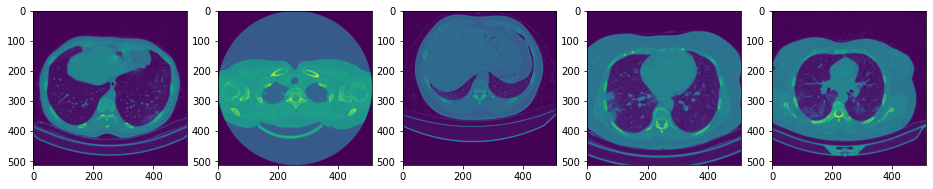

In [ ]:
# Plotting the 5 first covid images
fig, ax = plt.subplots(1, 5, figsize=(16, 4))
images = os.listdir(train_covid)[:5]  # First 5 images.
for i, img in enumerate(images):
  img = plt.imread(os.path.join(train_covid, img))
  ax[i].imshow(img)

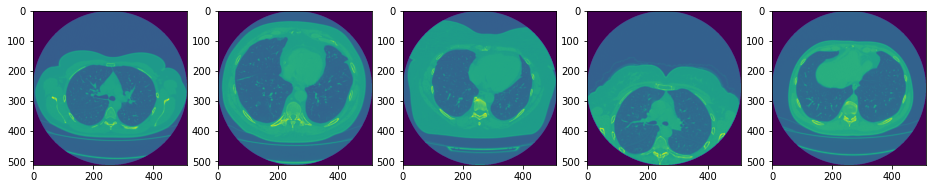

In [ ]:
# Plotting the 5 first normal images
fig, ax = plt.subplots(1, 5, figsize=(16, 4))
images = os.listdir(train_normal)[:5]
for i, img in enumerate(images):
  img = plt.imread(os.path.join(train_normal, img))
  ax[i].imshow(img)

In [10]:
TRAIN_PATH = '/content/gdrive/MyDrive/dl_covid19/output/train/'
TEST_PATH = '/content/gdrive/MyDrive/dl_covid19/output/test/'
VAL_PATH = '/content/gdrive/MyDrive/dl_covid19/output/val/'
BATCH_SIZE = 16

## 3. Creating First Model
We need to resize images (128,128) for faster training.
CAP-CT images were remowed.

In [ ]:
# Image augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator 
train_gen = train_datagen.flow_from_directory(TRAIN_PATH,
                                                batch_size=BATCH_SIZE,
                                              color_mode='grayscale',
                                              shuffle=True,
                                              target_size=(128,128),
                                              class_mode='binary')

# Test data generator
test_gen = test_datagen.flow_from_directory(TEST_PATH, 
                                             target_size=(128,128), 
                                             color_mode='grayscale',
                                             shuffle=True, class_mode='binary',
                                             batch_size=BATCH_SIZE)

# Validation data generator
val_gen = test_datagen.flow_from_directory(VAL_PATH, 
                                             target_size=(128,128), 
                                             color_mode='grayscale',
                                             shuffle=True, class_mode='binary',
                                             batch_size=BATCH_SIZE)


Found 11589 images belonging to 2 classes.
Found 1450 images belonging to 2 classes.
Found 1448 images belonging to 2 classes.


In [ ]:
lmodel = Sequential()

lmodel.add(Conv2D(128, (3,3), activation='relu', padding='valid' , # No padding
                  input_shape=(128,128, 1)))  # Creates convolution kernel
lmodel.add(MaxPooling2D(pool_size=(2,2))) # Downsample the input along its spatial dimensions

lmodel.add(Conv2D(64,(3, 3), activation='relu', padding='valid'))
lmodel.add(MaxPooling2D(pool_size=(2,2)))

lmodel.add(Flatten())   # Flattening involves transforming the entire pooled feature map
                        # Turns matrix into a vector

lmodel.add(Dense(32, activation='relu'))
lmodel.add(Dropout(0.5)) # For prevent overfitting - trains an ensemble of subnetweorks with shared parameters.

lmodel.add(Dense(1, activation='sigmoid'))

In [ ]:
import visualkeras

visualkeras.layered_view(lmodel).show()  # display using your system viewer.
visualkeras.layered_view(lmodel, to_file='output.png') # Write to disk
visualkeras.layered_view(lmodel, to_file='output.png').show()  # write and show

visualkeras.layerd_view(lmodel)

In [ ]:
lmodel.summary()

In [ ]:
lmodel.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=2e-5), metrics=['accuracy'])

history = lmodel.fit_generator(train_gen, verbose=1, validation_data = val_gen,
                               validation_steps=50, steps_per_epoch=100,
                               epochs=100)

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

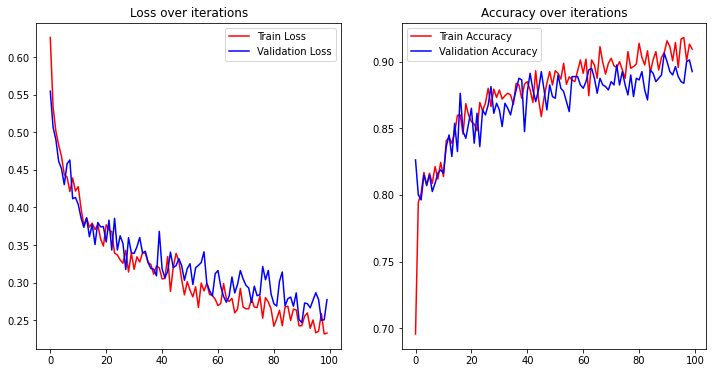

In [ ]:
n = len(history.history['loss'])
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history['loss']), 'r', label='Train Loss')
ax.plot(range(n), (history.history['val_loss']), 'b', label='Validation Loss')
ax.legend()
ax.set_title('Loss over iterations')


ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history['accuracy']), 'r', label='Train Accuracy')
ax.plot(range(n), (history.history['val_accuracy']), 'b', label='Validation Accuracy')
ax.legend()
ax.set_title('Accuracy over iterations')



In [ ]:
predicts = (lmodel.predict(test_gen) > 0.5).astype("int32")

In [ ]:
cm_l = confusion_matrix(test_gen.classes, predicts)
cm_pdl = pd.DataFrame(cm_l , index = ['0','1'] , columns = ['0','1'])

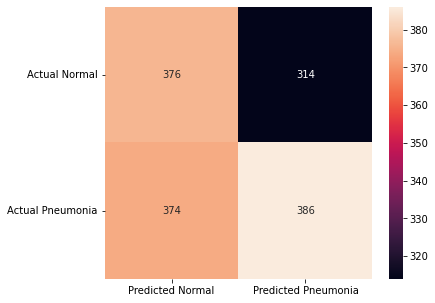

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_pdl,annot = True, fmt='',
xticklabels = ['Predicted Normal', 'Predicted Covid'],
yticklabels = ['Actual Normal', 'Actual Covid'])
plt.yticks(rotation=0)
plt.show()

# Something is anormal in here
#### TODO

In [ ]:
# Make a prediction
y_pred_kerasl = lmodel.predict(test_gen, val_gen.samples //
                                         val_gen.batch_size+1)
fpr_kerasl, tpr_kerasl, thresholds_kerasl = roc_curve(test_gen.classes,
                                                      y_pred_kerasl)
auc_kerasl = auc(fpr_kerasl, tpr_kerasl)
auc_kerasl

0.4667133867276887

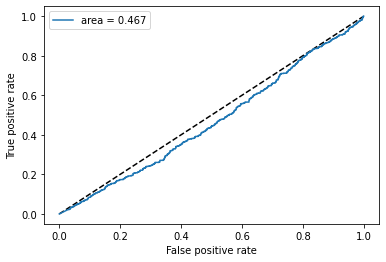

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_kerasl, tpr_kerasl, label='area = {:.3f}'.format(auc_kerasl))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()


In [ ]:
lmodel.save('/content/gdrive/MyDrive/dl_covid19/output/lcovid.h5')

## 4. Second Model

In [11]:
# Image augmentation ***** Seperator part
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    horizontal_flip=True, # Randomly flipping half the images horizontally
                                    rotation_range=5, # In value of degrees, a range within which to randomly rotate pictures
                                    width_shift_range=0.05, 
                                    height_shift_range=0.05,
                                    shear_range=0.05, # randomly applying shear tranformations
                                    zoom_range=0.05 # randomly zooming images
                                    ) 

test_datagen = ImageDataGenerator(rescale=1./255) # Data augmentation techniques ONLY for the train_datagen

# Training data generator
train_gen = train_datagen.flow_from_directory(TRAIN_PATH,
                                              batch_size=BATCH_SIZE,
                                              color_mode='grayscale',
                                              shuffle=True,
                                              target_size=(128,128),
                                              class_mode='binary')

# Validation data generator
val_gen = test_datagen.flow_from_directory(VAL_PATH, 
                                            target_size=(128,128), 
                                            color_mode='grayscale',
                                            shuffle=True,
                                            class_mode='binary',
                                            batch_size=BATCH_SIZE)

# Test data generator
test_gen = test_datagen.flow_from_directory(TEST_PATH, 
                                            target_size=(128, 128),
                                            color_mode='grayscale',
                                            shuffle=True,
                                            class_mode='binary',
                                            batch_size=BATCH_SIZE)


Found 11589 images belonging to 2 classes.
Found 1448 images belonging to 2 classes.
Found 1450 images belonging to 2 classes.


In [12]:
print(train_gen.class_indices)
print(test_gen.class_indices)

{'1NonCOVID': 0, '2COVID': 1}
{'1NonCOVID': 0, '2COVID': 1}


In [13]:
model = Sequential()

model.add(Conv2D(128, (3,3), activation='relu', padding='valid',
                 input_shape=(128,128,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

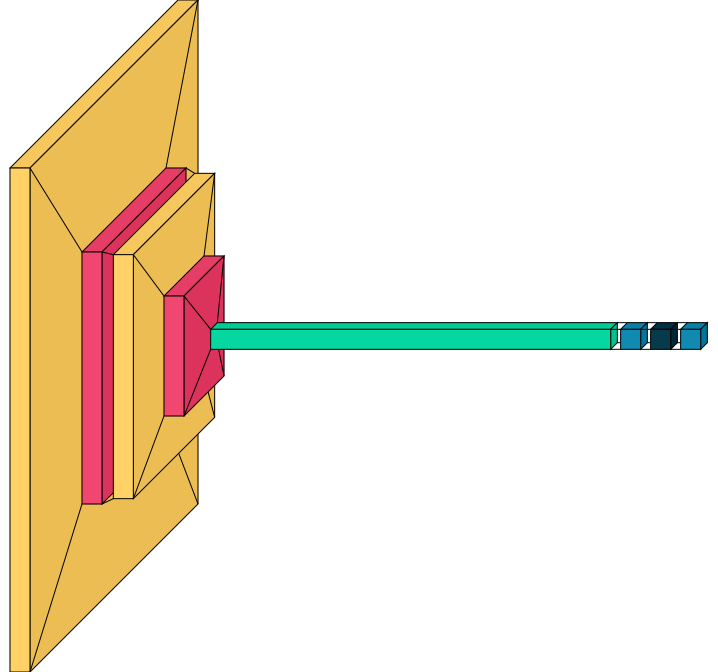

In [16]:
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show
visualkeras.layered_view(model)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 32)                1

In [18]:
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=2e-5), metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              verbose=1, 
                              validation_data = val_gen,
                              validation_steps=50, steps_per_epoch=100,
                              epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
100/100 [==============================] - 981s 10s/step - loss: 0.6699 - accuracy: 0.6344 - val_loss: 0.6257 - val_accuracy: 0.8138
Epoch 2/100
100/100 [==============================] - 683s 7s/step - loss: 0.6244 - accuracy: 0.7194 - val_loss: 0.5766 - val_accuracy: 0.7962
Epoch 3/100
100/100 [==============================] - 524s 5s/step - loss: 0.5867 - accuracy: 0.7550 - val_loss: 0.5178 - val_accuracy: 0.8163
Epoch 4/100
100/100 [==============================] - 426s 4s/step - loss: 0.5519 - accuracy: 0.7850 - val_loss: 0.5000 - val_accuracy: 0.8062
Epoch 5/100
100/100 [==============================] - 369s 4s/step - loss: 0.5277 - accuracy: 0.8012 - val_loss: 0.5225 - val_accuracy: 0.7850
Epoch 6/100
100/100 [==============================] - 321s 3s/step - loss: 0.5154 - accuracy: 0.8119 - val_loss: 0.4886 - val_accuracy: 0.8150
Epoch 7/100
100/100 [==============================] - 288s 3s/step - loss: 0.5301 - accuracy: 0.7900 - val_loss: 0.4774 - val_accuracy

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

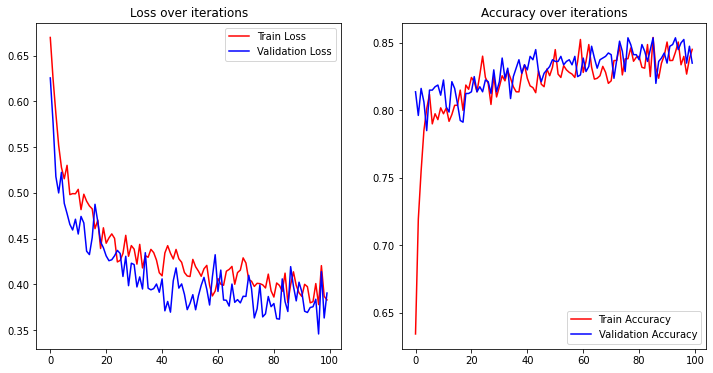

In [20]:
n = len(history.history['loss'])
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history['loss']), 'r', label='Train Loss')
ax.plot(range(n), (history.history['val_loss']), 'b', label='Validation Loss')
ax.legend()
ax.set_title('Loss over iterations')


ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history['accuracy']), 'r', label='Train Accuracy')
ax.plot(range(n), (history.history['val_accuracy']), 'b', label='Validation Accuracy')
ax.legend()
ax.set_title('Accuracy over iterations')


In [21]:
model.save('/content/gdrive/MyDrive/dl_covid19/output/covid.h5')

In [22]:
model = keras.models.load_model('/content/gdrive/MyDrive/dl_covid19/output/covid.h5')
predictions = (model.predict(test_gen) > .5).astype('int32')

In [23]:
cm = confusion_matrix(test_gen.classes, predictions)
cm_pd = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

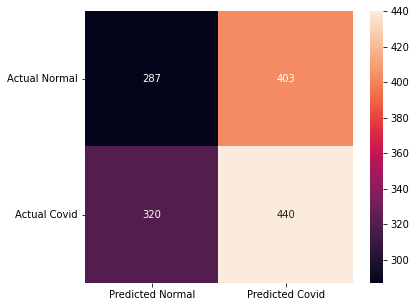

In [27]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_pd, annot=True, fmt='',
            xticklabels=['Predicted Normal', 'Predicted Covid'],
            yticklabels=['Actual Normal', 'Actual Covid'])
plt.yticks(rotation=0)
plt.show()

In [28]:
# Make a prediction
y_pred_keras = model.predict(test_gen, val_gen.samples //
                                       val_gen.batch_size + 1, verbose=1)
fpr_keras, tpr_keras, thresholds_keras=roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

91/91 [==============================] - 25s 273ms/step


0.489963768115942

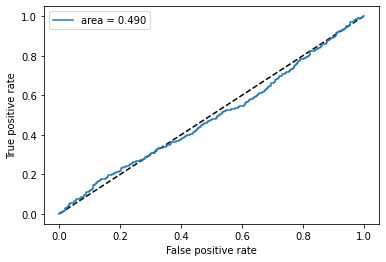

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

## 5.Third Model

In [32]:
conv_base = VGG16(weights='imagenet',
                  include_top=False)

In [62]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base.layers:
  layer.trainable = False

vgg_model = Sequential()
vgg_model.add(base)
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Flatten())
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation='sigmoid'))

vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dense_15 (Dense)            (None, 4, 4, 256)         131328    
                                                                 
 dropout_7 (Dropout)         (None, 4, 4, 256)         0         
                                                                 
 flatten_4 (Flatten)         (None, 4096)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               524416    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                

In [74]:
# Image augmentation
train_datagen_vgg16 = ImageDataGenerator(rescale=1./255, 
                                    horizontal_flip=True, # Randomly flipping half the images horizontally
                                    rotation_range=5, # In value of degrees, a range within which to randomly rotate pictures
                                    width_shift_range=0.05, 
                                    height_shift_range=0.05,
                                    shear_range=0.05, # randomly applying shear tranformations
                                    zoom_range=0.05 # randomly zooming images
                                    ) 

test_datagen_vgg16 = ImageDataGenerator(rescale=1./255) # Data augmentation techniques ONLY for the train_datagen

# Training data generator
train_gen_vgg16 = train_datagen_vgg16.flow_from_directory(TRAIN_PATH,
                                              batch_size=BATCH_SIZE,
                                              color_mode='grayscale',
                                              shuffle=True,
                                              target_size=(128,128),
                                              class_mode='binary')

# Validation data generator
val_gen_vgg16 = test_datagen_vgg16.flow_from_directory(VAL_PATH, 
                                            target_size=(128,128), 
                                            color_mode='grayscale',
                                            shuffle=True,
                                            class_mode='binary',
                                            batch_size=BATCH_SIZE)

# Test data generator
test_gen_vgg16 = test_datagen_vgg16.flow_from_directory(TEST_PATH, 
                                            target_size=(128, 128),
                                            color_mode='grayscale',
                                            shuffle=True,
                                            class_mode='binary',
                                            batch_size=BATCH_SIZE)


Found 11589 images belonging to 2 classes.
Found 1448 images belonging to 2 classes.
Found 1450 images belonging to 2 classes.


In [75]:
vgg_model = Sequential()
vgg_model.add(InputLayer(input_shape=(256,256,3)))
vgg_model.add(Lambda(lambda x: x/255.))   #Normalization

vgg_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(Dropout(0.1))
vgg_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(MaxPooling2D((2, 2)))

vgg_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(Dropout(0.1))
vgg_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(MaxPooling2D((2, 2)))

vgg_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(Dropout(0.2))
vgg_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(Dropout(0.2))
vgg_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(MaxPooling2D((2, 2)))

vgg_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(MaxPooling2D((2, 2)))

vgg_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
vgg_model.add(MaxPooling2D((2, 2)))

vgg_model.add(Flatten())
vgg_model.add(Dense(4096, activation="relu"))
vgg_model.add(Dense(4096, activation="relu"))
vgg_model.add(Dense(1, activation="sigmoid"))

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 dropout_9 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 128)     73856     
                                                      

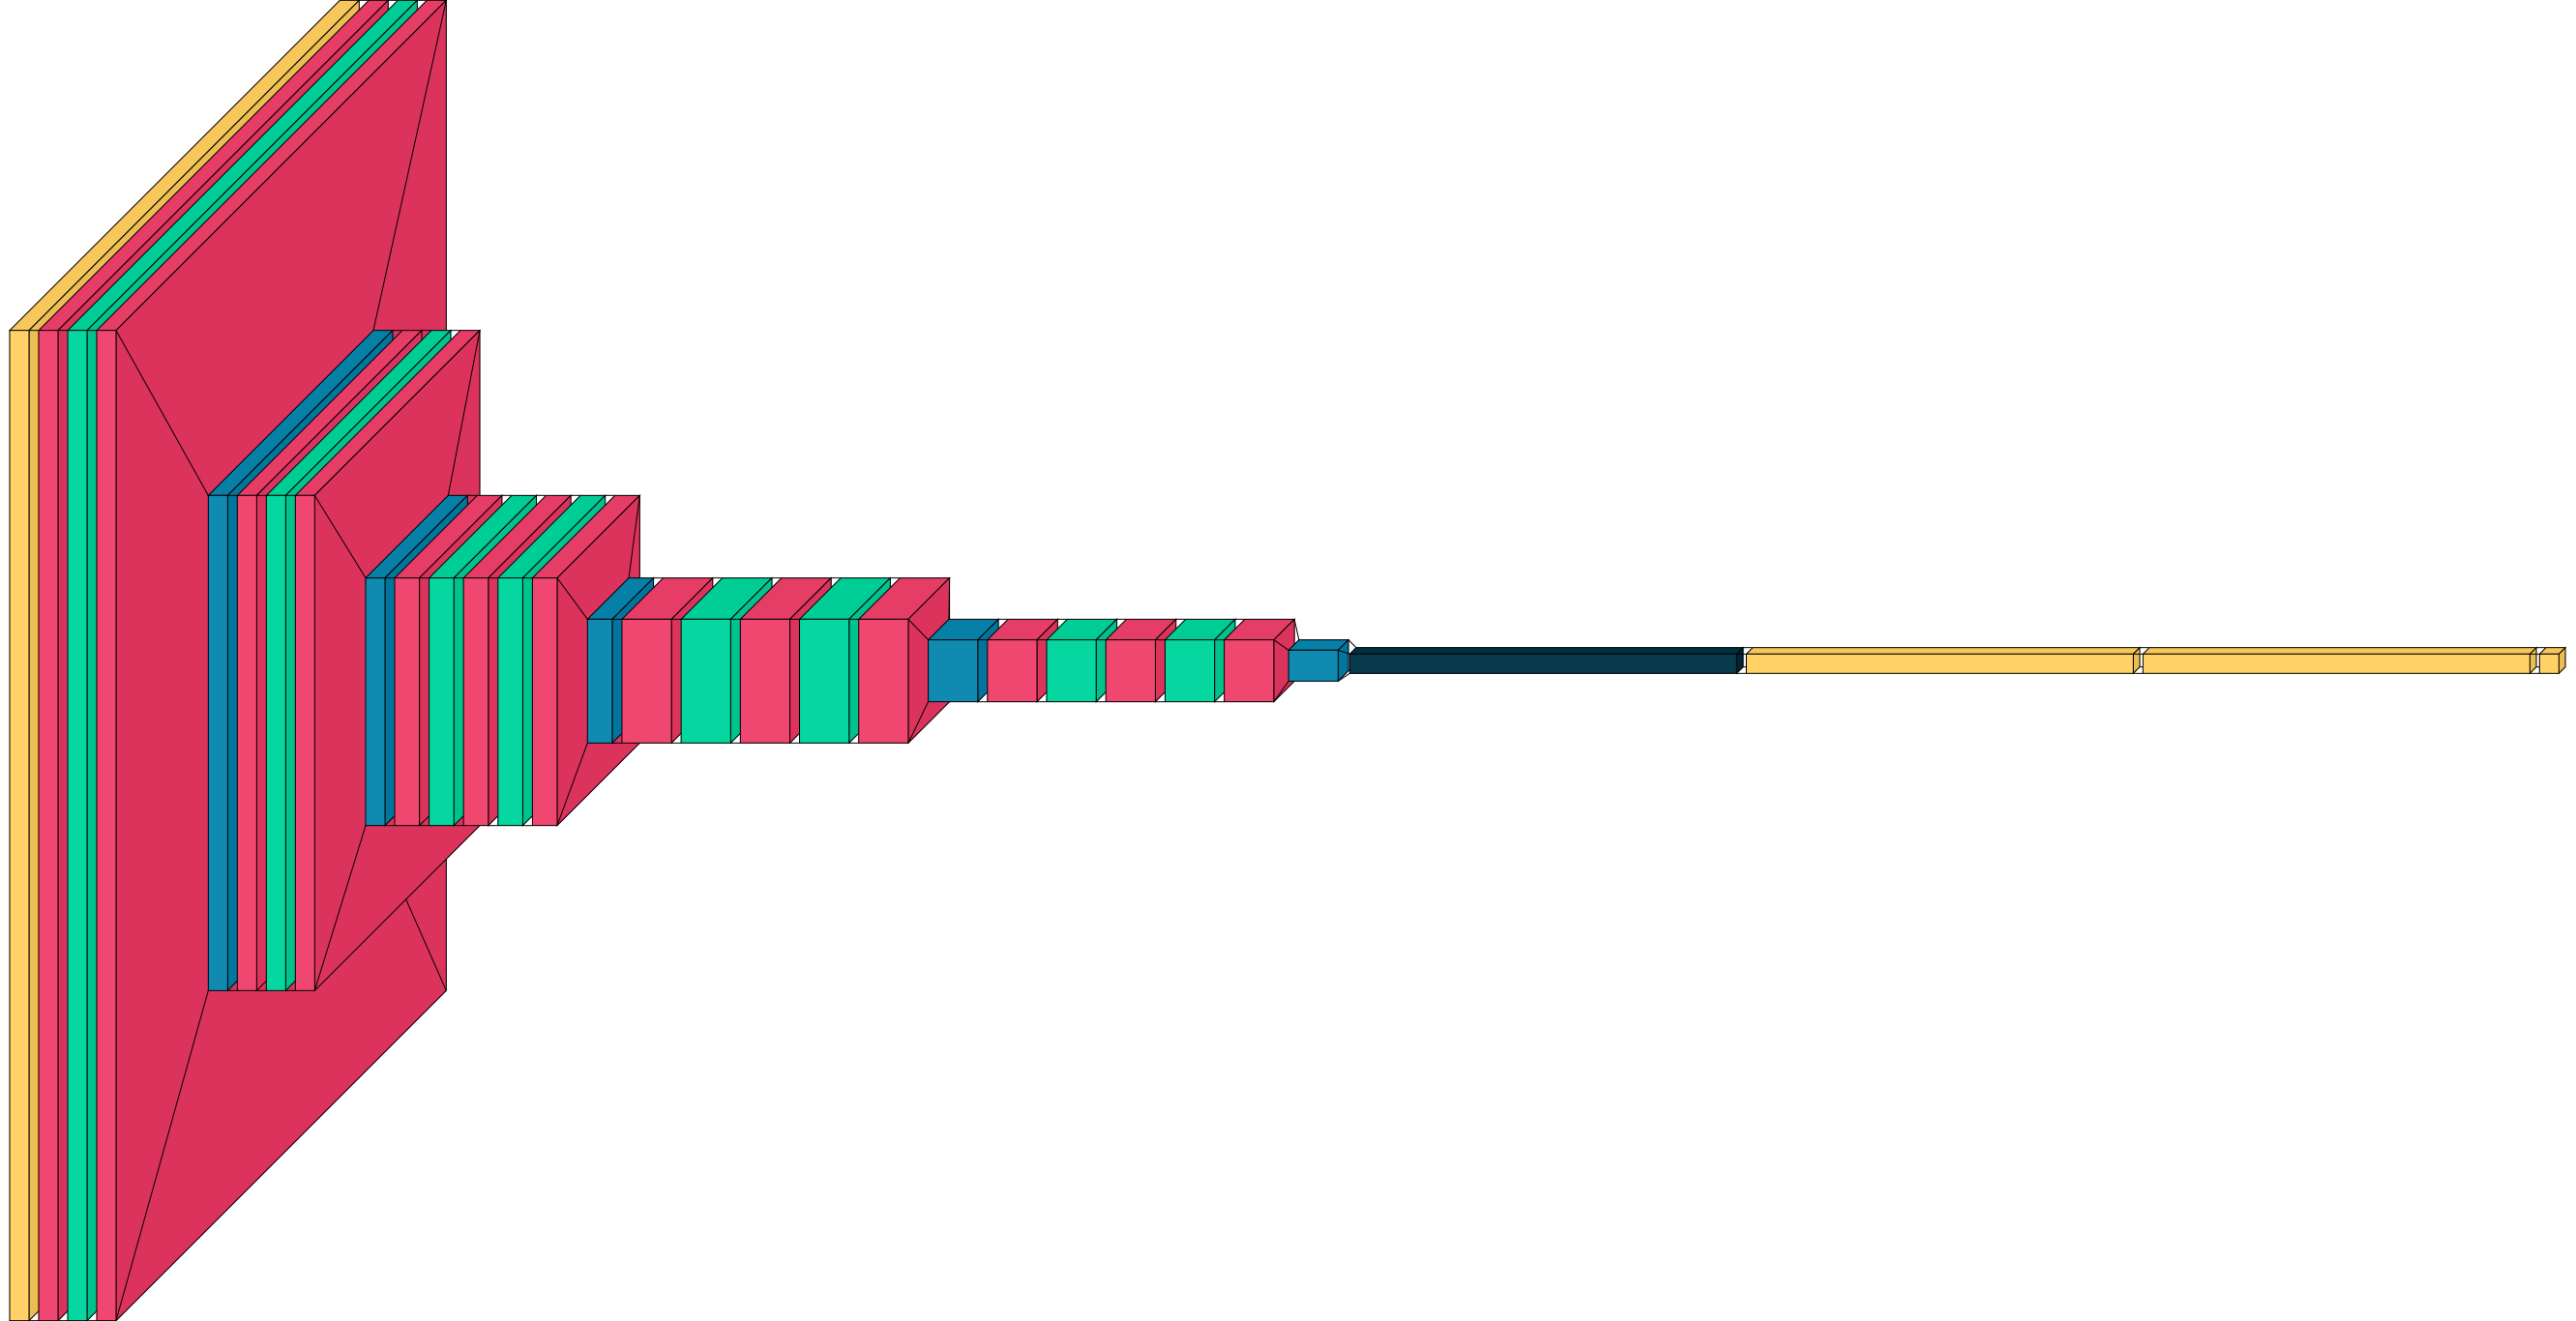

In [80]:
import visualkeras
visualkeras.layered_view(vgg_model).show() # display using your system viewer
visualkeras.layered_view(vgg_model, to_file='output.png') # write to disk
visualkeras.layered_view(vgg_model, to_file='output.png').show() # write and show
visualkeras.layered_view(vgg_model)

In [79]:
vgg_model.compile(loss='binary_crossentropy', optimizer= RMSprop(learning_rate=2e-5), metrics=['accuracy'])
history = vgg_model.fit(train_gen_vgg16, verbose=1, validation_data = val_gen_vgg16, validation_steps = 50, steps_per_epoch = 100, epochs=100)

Epoch 1/100


InvalidArgumentError: ignored

In [65]:
vgg_model.save('/content/gdrive/MyDrive/dl_covid19/output/vgg_covid.h5')

In [66]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

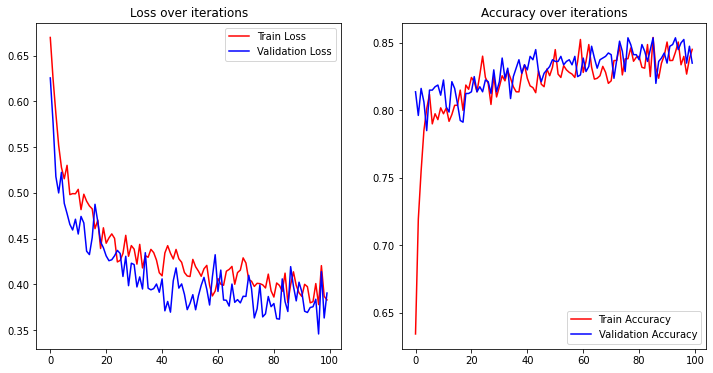

In [67]:
n = len(history.history['loss'])
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history['loss']), 'r', label='Train Loss')
ax.plot(range(n), (history.history['val_loss']), 'b', label='Validation Loss')
ax.legend()
ax.set_title('Loss over iterations')


ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history['accuracy']), 'r', label='Train Accuracy')
ax.plot(range(n), (history.history['val_accuracy']), 'b', label='Validation Accuracy')
ax.legend()
ax.set_title('Accuracy over iterations')

In [68]:
vgg16_predictions = (vgg_model.predict(test_gen) > .5).astype('int32')
cm_16 = confusion_matrix(test_gen_vgg16.classes, vgg16_predictions)
cm_pd_16 = pd.DataFrame(cm_16, index=['0', '1'], columns=['0', '1'])

plt.figure(figsize=(6,5))
sns.heatmap(cm_pd_16, annot=True, 
            xticklabels=['Predicted Normal', 'Predicted Covid'],
            yticklabels=['Actual Normal', 'Actual Covid'])
plt.yticks(rotation=0)
plt.show()

InvalidArgumentError: ignored

In [78]:
# Make a prediction
y_pred_keras_vgg = vgg_model.predict(test_gen_vgg16, val_gen_vgg16.samples //
                                       val_gen_vgg16.batch_size + 1, verbose=1)
fpr_keras_vgg, tpr_keras_vgg, thresholds_keras_vgg=roc_curve(test_gen_vgg16.classes, y_pred_keras_vgg)
auc_keras_vgg = auc(fpr_keras_vgg, tpr_keras_vgg)
auc_keras_vgg

InvalidArgumentError: ignored

NameError: ignored

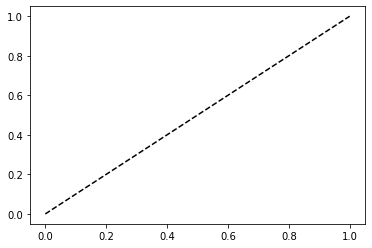

In [69]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_vgg, tpr_keras_vgg, label='area = {:.3f}'.format(auc_keras_vgg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

## 6.Conclusion
A dataset of over 10.000 CT images was used to generate three convolutional neural network algorithms for accurately predicting whether or not an individual has developed COVID-19 for this research.

The AUC indicates how well the model distinguishes across classes. The greater the AUC, the better.

Recommendation: Despite its simplicity, the first model appears to produce the best results, with better accuracies and accurate predictions than the other two models.

## 7. Next Steps

The predictions heatmap, on the other hand, reveals that the first model misclassifies a large number of photos. It was put to the test on a collection of 1450 photos, and 10% of them were incorrectly classified. There are various things you may take to correct this, including:

• Switch to a new CNN model (add more hidden layers, tweak the hyperparameters etc.). The disadvantage would be that the training procedure would take much longer in the end.

• Using k-fold cross validation in conjunction with hyperparameter tuning approaches (such as kerastuner) determines the best number of layers for the situation at hand). The training procedure would need a significant amount of time.

• Using a different CNN architecture that has been pre-trained.

• Make the photos a different form. The photos were reduced to 128x128 pixels in this case.